#### Library

In [1]:
import pandas as pd
# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

from xgboost import XGBRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

#### Data Loading

In [2]:
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [3]:
print(df2021.shape)
print(df2022.shape)
print(df2023.shape)
print(df2024.shape)

(8763, 67)
(8763, 67)
(8763, 67)
(8787, 67)


In [4]:
df = pd.concat([df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [6]:
df.shape

(35076, 67)

In [8]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,week_of_month,month,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2021-01-01 00:00:00,9655.0,9718.0,29.92,32.91,38.45,0.0,-3.2,-5.8,-8.9,1470.686241,13.0,13.0,10.0,0,4,53,1,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
1,2021-01-01 01:00:00,9513.0,9573.0,27.48,27.10,38.44,0.0,2.5,-7.8,-8.6,1525.467843,30.0,13.0,10.0,1,4,53,1,1,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
2,2021-01-01 02:00:00,9437.0,9446.0,28.62,27.13,38.44,0.0,2.0,-10.4,-8.5,1535.146498,23.0,9.0,10.0,2,4,53,1,1,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
3,2021-01-01 03:00:00,9376.0,9366.0,33.55,32.14,38.43,0.0,2.4,-11.9,-8.5,1484.051400,24.0,4.0,10.0,3,4,53,1,1,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0
4,2021-01-01 04:00:00,9356.0,9357.0,35.36,35.64,38.43,0.0,2.4,-9.6,-8.9,1446.955595,22.0,4.0,10.0,4,4,53,1,1,33.55,28.62,27.48,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,29.92,9376.0,9437.0,9513.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0,9655.0


In [11]:
# Check for missing values
df.isnull( ).sum().sort_values(ascending=False)

datetime_                         0
alberta_internal_load_lag_8       0
pool_price_lag_18                 0
pool_price_lag_19                 0
pool_price_lag_20                 0
pool_price_lag_21                 0
pool_price_lag_22                 0
pool_price_lag_23                 0
pool_price_lag_24                 0
alberta_internal_load_lag_1       0
alberta_internal_load_lag_2       0
alberta_internal_load_lag_3       0
alberta_internal_load_lag_4       0
alberta_internal_load_lag_5       0
alberta_internal_load_lag_6       0
alberta_internal_load_lag_7       0
alberta_internal_load_lag_9       0
pool_price_lag_16                 0
alberta_internal_load_lag_10      0
alberta_internal_load_lag_11      0
alberta_internal_load_lag_12      0
alberta_internal_load_lag_13      0
alberta_internal_load_lag_14      0
alberta_internal_load_lag_15      0
alberta_internal_load_lag_16      0
alberta_internal_load_lag_17      0
alberta_internal_load_lag_18      0
alberta_internal_load_lag_19

#### Train-Test split

In [12]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < '2024-12-01']
test_data = df[df['datetime_'] >= '2024-12-01']

# Define independent variables (features) and target variable
# X_train = train_data[['solar_generation', 'wind_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc']]
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']

# Display the shapes of the training data
print(X_train.shape, y_train.shape)


# Filter data for the first 6 months
test_data = df[df['datetime_'] >= '2024-12-01']

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']

# Display the shapes of the training data
print(X_test.shape, y_test.shape)

(34332, 65) (34332,)
(744, 65) (744,)


#### Model Training

In [15]:
# Initialize the CatBoost regressor
catboost_regressor = CatBoostRegressor(iterations=5000, learning_rate=0.1, depth=6, loss_function='RMSE')

# # Specify the categorical features
# categorical_features = ['season'] 

# Train the model
catboost_regressor.fit(X_train, y_train, verbose=100) #cat_features=categorical_features, 

# Display the model
print(catboost_regressor)

0:	learn: 156.3519300	total: 131ms	remaining: 10m 54s
100:	learn: 53.5920980	total: 1.98s	remaining: 1m 35s
200:	learn: 48.8313115	total: 3.79s	remaining: 1m 30s
300:	learn: 45.7194707	total: 5.5s	remaining: 1m 25s
400:	learn: 43.2132479	total: 7.26s	remaining: 1m 23s
500:	learn: 40.8542904	total: 9s	remaining: 1m 20s
600:	learn: 38.7869442	total: 10.7s	remaining: 1m 18s
700:	learn: 36.9796661	total: 12.4s	remaining: 1m 15s
800:	learn: 35.2554745	total: 14.3s	remaining: 1m 15s
900:	learn: 33.6436057	total: 16s	remaining: 1m 12s
1000:	learn: 32.2396796	total: 17.6s	remaining: 1m 10s
1100:	learn: 31.0066406	total: 19.3s	remaining: 1m 8s
1200:	learn: 29.9286070	total: 20.9s	remaining: 1m 6s
1300:	learn: 28.8527372	total: 22.6s	remaining: 1m 4s
1400:	learn: 27.7700722	total: 24.2s	remaining: 1m 2s
1500:	learn: 26.7876398	total: 26.1s	remaining: 1m
1600:	learn: 25.8371337	total: 27.8s	remaining: 59s
1700:	learn: 24.9214711	total: 29.5s	remaining: 57.1s
1800:	learn: 24.0367824	total: 31.1s	r

#### Train Inference

In [16]:
# Make predictions on the training data
y_train_pred = catboost_regressor.predict(X_train)

# Display the predictions
print(y_train_pred)
# Calculate mean squared error for training data
train_mse = mean_squared_error(y_train, y_train_pred)
print(f"Train Mean Squared Error: {train_mse}")

# Calculate R^2 score for training data
train_r2 = r2_score(y_train, y_train_pred)
print(f"Train R^2 Score: {train_r2}")

[30.59323543 26.31790132 26.85881198 ... 38.40624162 37.38626823
 28.72248745]
Train Mean Squared Error: 106.90024109650506
Train R^2 Score: 0.9962933656572608


#### Test Inference

In [17]:
# Make predictions on the test data
y_pred = catboost_regressor.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

Mean Squared Error: 637.628061829243
R^2 Score: -0.21466267528096217


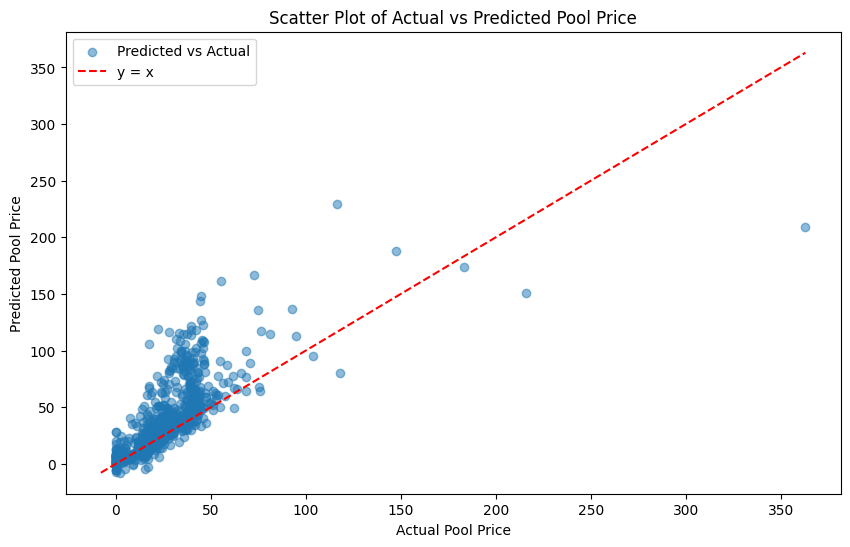

In [18]:
# Assuming y_test and y_pred are already defined
# Generate values for the y = x line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
line_values = np.linspace(min_val, max_val, 100)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')

# Plot the y = x line
plt.plot(line_values, line_values, color='red', linestyle='--', label='y = x')

# Add labels and title
plt.xlabel('Actual Pool Price')
plt.ylabel('Predicted Pool Price')
plt.title('Scatter Plot of Actual vs Predicted Pool Price')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# train for higher iterations
# gather large data and train model (shown performance boost when trained on 2024 data relative to June_dec_2024 data)
# train LSTM model